In [ ]:
!nvidia-smi

Sun Jun 20 21:59:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/TELECOM MS BGD/Fil_rouge/Welding.zip'

Archive:  /content/drive/MyDrive/TELECOM MS BGD/Fil_rouge/Welding.zip
  inflating: Welding/.DS_Store       
  inflating: Welding/W0004/W0004_0001.png  
  inflating: Welding/W0004/W0004_0008.png  
  inflating: Welding/W0004/W0004_0002.png  
  inflating: Welding/W0004/W0004_0006.png  
  inflating: Welding/W0004/W0004_0004.png  
  inflating: Welding/W0004/W0004_0007.png  
  inflating: Welding/W0004/W0004_0009.png  
  inflating: Welding/W0004/W0004_0003.png  
  inflating: Welding/W0002/W0001_0049.png  
  inflating: Welding/W0002/W0001_0048.png  
  inflating: Welding/W0002/W0001_0014.png  
  inflating: Welding/W0002/W0002_readme.txt  
  inflating: Welding/W0002/W0001_0017.png  
  inflating: Welding/W0002/W0001_0012.png  
  inflating: Welding/W0002/W0001_0000.png  
  inflating: Welding/W0002/ground_truth.txt  
  inflating: Welding/W0002/W0001_0038.png  
  inflating: Welding/W0002/W0001_0013.png  
  inflating: Welding/W0002/W0001_0016.png  
  inflating: Welding/W0002/W0001_0026.png  
  inflat

In [ ]:
import os, pickle, tarfile
from PIL import Image
from tqdm import tqdm
import urllib.request
import torch
from torchvision import transforms as T
import numpy as np
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis
from skimage import morphology
from skimage.segmentation import mark_boundaries
import matplotlib

# DataSet

In [ ]:
import os
from skimage import io

import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

from google.colab import drive

In [ ]:
class WeldingsTestDataset(Dataset):
    """Weldings Test dataset."""

    def __init__(self, image_dir, masks_dir, clean_dir, transform=None):

        self.filelist = [file for file in os.listdir(image_dir) if file.endswith('.png')]
        dirty_filelist = [file for file in os.listdir(clean_dir) if file.endswith('.png')]
        dirty_filelist = [file for file in dirty_filelist if file[-5] in '05']
        self.filelist.extend(dirty_filelist)

        self.image_dir = image_dir
        self.masks_dir = masks_dir
        self.clean_dir = clean_dir
        self.transform = transform

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.filelist[idx].startswith('W'):
          img_name = os.path.join(self.image_dir, self.filelist[idx])
          image = io.imread(img_name)
          mask_name = os.path.join(self.masks_dir, self.filelist[idx])
          mask = io.imread(mask_name)
        else:
          img_name = os.path.join(self.clean_dir, self.filelist[idx])
          image = io.imread(img_name)
          mask = np.zeros_like(image)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)[0,:,:]

        # Anomaly by default
        label = 1
        if torch.max(mask) == 0:
          label = 0

        sample = [image, label, mask]

        return sample

In [ ]:
image_folder = '/content/Welding/W0001'
masks_folder = '/content/Welding/W0002'
clean_folder = '/content/drive/MyDrive/TELECOM MS BGD/Fil_rouge/clean' 
#image_folder = '/content/drive/MyDrive/Welding/W0001'
#masks_folder = '/content/drive/MyDrive/Welding/W0002'
#clean_folder = '/content/drive/MyDrive/gdxray_selected_patches/clean'

transformations = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.CenterCrop(256),
                                      transforms.Pad(15),
                                      transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
                                      ])

test_dataset = WeldingsTestDataset(image_dir=image_folder,
                                   masks_dir=masks_folder,
                                   clean_dir=clean_folder,
                                   transform=transformations)
len(test_dataset)

85

1 torch.Size([3, 286, 286]) 1 torch.Size([286, 286])


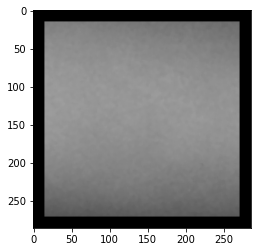

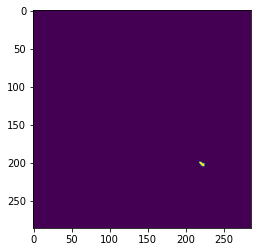

In [ ]:
fig = plt.figure()

for i in range(len(test_dataset)):
  sample = test_dataset[i]

  if sample[1] == 1:

    print(i, sample[0].shape, sample[1], sample[2].shape)

    plt.tight_layout()
    plt.imshow(torch.moveaxis(sample[0], 0, -1))
    plt.show()
    plt.imshow(torch.moveaxis(sample[2], 1, -1))
    plt.show()
    break

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

tensor([1, 1, 1, 0])


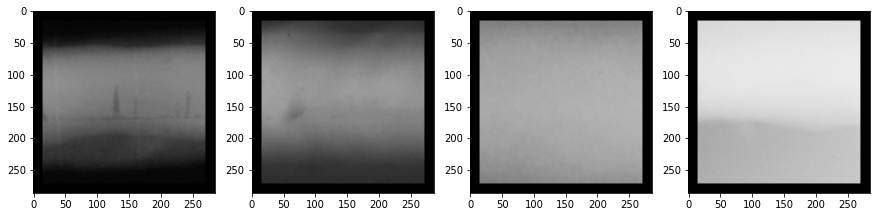

In [ ]:
f, ax = plt.subplots(1, 4, figsize=(15, 15))


for i_batch, (images, label, masks) in enumerate(test_dataloader):
    print(label)
    images = images.cpu().detach()
    for i, image in enumerate(images):
      ax[i].imshow(torch.moveaxis(image, 0, -1))
    plt.show()
    break


0 torch.Size([4, 3, 286, 286]) tensor([1, 0, 1, 0])
tensor(0.) tensor(1.) tensor([0., 1.])


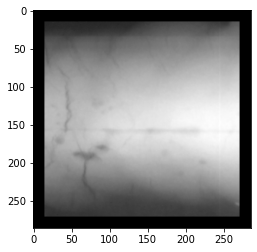

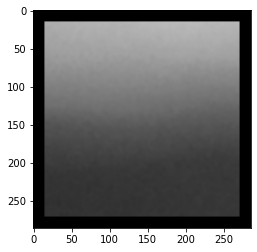

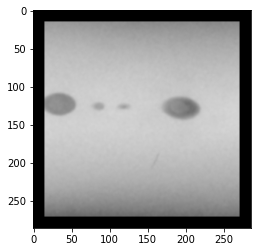

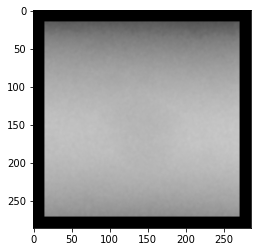

tensor(43)


In [ ]:
labels = 0

for i_batch, (images, label, masks) in enumerate(test_dataloader):
    labels += label.sum()
    if i_batch < 1:
      print(i_batch, images.size(), label)
      print(masks.min(), masks.max(), torch.unique(masks))
      for image in images:
        plt.imshow(torch.moveaxis(image, 0, -1))
        plt.show()
print(labels)

In [ ]:
class WeldingsTrainDataset(Dataset):
    """Weldings Train dataset."""

    def __init__(self, root_dir, transform=None):

        filelist = [file for file in os.listdir(root_dir) if file.endswith('.png')]
        filelist = [file for file in filelist if file[-5] in '12346789']
        
        self.filelist = filelist

        self.image_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.filelist[idx])
        image = io.imread(img_name)

        # Create empty anomaly mask
        mask = np.zeros_like(image)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)[0,:,:]

        label = 0
        
        sample = [image, label, mask]

        return sample

In [ ]:
root_folder = '/content/drive/MyDrive/TELECOM MS BGD/Fil_rouge/clean'

# Arnaud
#root_folder = '/content/drive/MyDrive/gdxray_selected_patches/clean'

transformations = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.CenterCrop(256),
                                      transforms.Pad(15),
                                      transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
                                      ])

train_dataset = WeldingsTrainDataset(root_dir=root_folder, transform=transformations)
len(train_dataset)

114

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

0 torch.Size([4, 3, 286, 286]) tensor([0, 0, 0, 0]) torch.Size([4, 286, 286])
tensor(0.) tensor(0.)


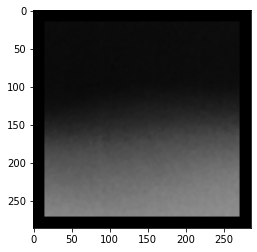

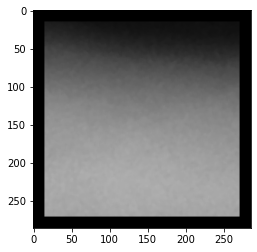

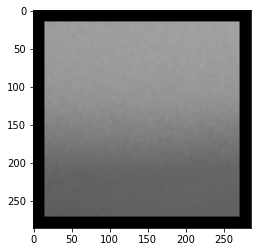

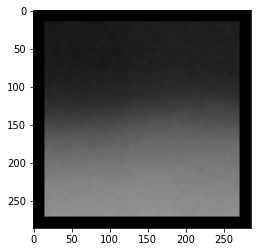

In [ ]:
for i_batch, (images, label, masks) in enumerate(train_dataloader):
    print(i_batch, images.size(), label, masks.size())
    print(masks.min(), masks.max())
    for image in images:
      plt.imshow(torch.moveaxis(image, 0, -1))
      plt.show()
    break

# PADIM

In [ ]:
import matplotlib.pyplot as plt
import pickle
from pickle import dump, load
import os
from random import sample
from torch.utils.data import DataLoader, TensorDataset
from collections import OrderedDict
import gc
import torch
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import torch.nn.functional as F
import torch.nn as nn

AVAILABLE_MODEL = ['resnet18', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d', 'wide_resnet50_2', 'wide_resnet101_2']

def get_model(modeltype):
    assert modeltype in AVAILABLE_MODEL
    if 'resne' in modeltype:
        if modeltype == 'resnet18':
            from torchvision.models import resnet18 as modelfun
        elif modeltype == 'resnet50':
            from torchvision.models import resnet50 as modelfun
        elif modeltype == 'resnet101':
            from torchvision.models import resnet101 as modelfun
        elif modeltype == 'resnet152':
            from torchvision.models import resnet152 as modelfun
        elif modeltype == 'resnext50_32x4d':
            from torchvision.models import resnext50_32x4d as modelfun
        elif modeltype == 'resnext101_32x8d':
            from torchvision.models import resnext101_32x8d as modelfun
        elif modeltype == 'wide_resnet50_2':
            from torchvision.models import wide_resnet50_2 as modelfun
        elif modeltype == 'wide_resnet101_2':
            from torchvision.models import wide_resnet101_2 as modelfun
        else:
            raise NotImplementedError(f'{modeltype} is not found')
        model = modelfun(pretrained=True, progress=True)
        #model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3),  bias=False)
        #model.bn1 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        layer_name = ['layer1', 'layer2', 'layer3']  #add 'avgpool' for Spade
        layer4feat = ['layer1', 'layer2', 'layer3']
        return model, layer_name, layer4feat
    else:
        raise NotImplementedError(f'{modeltype} is not found')

@torch.no_grad()
def calc_dist_matrix(x, y):
    n, m, d = x.size(0), y.size(0), x.size(1)
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    dist_matrix = torch.sqrt(torch.pow(x - y, 2).sum(2))
    return dist_matrix
# %%

class SpadeBase(object):
    def __init__(self, modeltype, device):
        model, self.layer_name, self.layer4feat = get_model(
            modeltype=modeltype)
        self.model = model.to(device)
        self.device = device
        self.model.eval()

    @torch.no_grad()
    def forward(self, loader, is_train=True):
        outputs = []
        def hook(module, input, output):
            outputs.append(output.detach())
        for layername in self.layer_name:
            layer = getattr(self.model, layername)
            if layername == 'avgpool':
                layer.register_forward_hook(hook)
            else:
                layer[-1].register_forward_hook(hook)
                setattr(self.model, layername, layer)
        output_dict = OrderedDict([(layer, []) for layer in self.layer_name])
        self.model.eval()
        phase = 'train' if is_train else 'test'
        for (data, _, _) in tqdm(loader, f'| feature extraction | {phase} |'):  #a quoi servent les "_"
            with torch.no_grad():
                pred = self.model(data.to(self.device))
            del pred
            for k, v in zip(output_dict.keys(), outputs):
                output_dict[k].append(v.cpu().detach())
            outputs = []
            gc.collect()
        for k, v in output_dict.items():
            output_dict[k] = torch.cat(v, 0)
        return output_dict

class Padim(SpadeBase):
    def __init__(self, modeltype, device, t_d=1700 , d=550,  *args, **kwargs): #td moitié des pixels , d = 550 * 550 --> dim mat cov
        super().__init__(modeltype, device)
        self.t_d = t_d
        self.d = d
        self.idx = torch.tensor(sample(range(0, self.t_d), self.d))
    
    def embedding_concat(self, x, y):
        B, C1, H1, W1 = x.size()
        _, C2, H2, W2 = y.size()
        s = int(H1 / H2)
        x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
        x = x.view(B, C1, -1, H2, W2)
        z = torch.zeros(B, C1 + C2, x.size(2), H2, W2)
        for i in range(x.size(2)):
            z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
        z = z.view(B, -1, H2 * W2)
        z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
        return z

    def fit(self, loader):
        # retrieve features map 
        latent_embedding = self.forward(loader, is_train=True)
        # Embedding concat
        embedding_vectors = latent_embedding['layer1']
        print('+Compute Embedding')
        for layer_name in ['layer2', 'layer3']:
            embedding_vectors = self.embedding_concat(embedding_vectors, latent_embedding[layer_name])
        # randomly select d dimension
        embedding_vectors = torch.index_select(embedding_vectors, 1, self.idx)
        # calculate multivariate Gaussian distribution
        print('Estimate Gaussian Distribution')
        self.latent_embedding = self.compute_gaussian_distrib(embedding_vectors)
        return self.latent_embedding
        
    @torch.no_grad()
    def compute_gaussian_distrib(self, embedding_vectors):
        '''
        H et W sont la largeur et la hauteur du patch
        '''
        B, C, H, W = embedding_vectors.size()
        embedding_vectors = embedding_vectors.view(B, C, H * W)
        mean = torch.mean(embedding_vectors, dim=0).numpy()
        cov = torch.zeros(C, C, H * W).numpy()
        I = np.identity(C)
        for i in range(H * W):
            cov[:, :, i] = np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I
        # save learned distribution
        latent_embedding = [mean, cov]
        return latent_embedding

    def transform(self, loader):
        return self.forward(loader, is_train=False)

    def predict_score(self, loader, size=None):
        """   # 
        le size ici il correspond a la taille de l'image qu'on lui donne en entré comme on lui donne des images carrés c'est bien 

        """
        #repars apres les features deja chargés 
        if isinstance(loader, DataLoader):
            latent_embedding_test = self.transform(loader)

        embedding_vectors = latent_embedding_test['layer1']
        for layer_name in ['layer2', 'layer3']:
            embedding_vectors = self.embedding_concat(embedding_vectors, latent_embedding_test[layer_name])
        # randomly select d dimension
        embedding_vectors = torch.index_select(embedding_vectors, 1, self.idx)
        score_map = F.interpolate(self.distance_matrix(embedding_vectors).unsqueeze(1), size=size, mode='bilinear', align_corners=False).squeeze().numpy()
        # apply gaussian smoothing on the score map
        for i in range(score_map.shape[0]):
            score_map[i] = gaussian_filter(score_map[i], sigma=4)

        return score_map

    @torch.no_grad()
    def distance_matrix(self, embedding_vectors):   #latent_embedding --> train
      # calculate distance matrix
      B, C, H, W = embedding_vectors.size()
      embedding_vectors = embedding_vectors.view(B, C, H * W).numpy()
      dist_list = []
      for i in range(H * W):
          mean = self.latent_embedding[0][:, i]
          conv_inv = np.linalg.inv(self.latent_embedding[1][:, :, i])
          dist = [mahalanobis(sample[:, i], mean, conv_inv) for sample in embedding_vectors]
          dist_list.append(dist)

      dist_list = np.array(dist_list).transpose(1, 0).reshape(B, H, W)
      # upsample
      dist_list = torch.tensor(dist_list)
      return dist_list


def denormalization(x):
    mean = np.array([0.5]) #correspond au moyenne de chaque couche
    std = np.array([0.5])
    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)    
    return x

def plot_fig(test_img, scores, gts, threshold, save_dir):
    num = len(scores)
    vmax = scores.max() * 255.
    vmin = scores.min() * 255.
    for i in range(num):
        img = test_img[i]
        img = denormalization(img)
        gt = gts[i].transpose(1, 2, 0).squeeze()
        heat_map = scores[i] * 255
        mask = scores[i]
        mask[mask > threshold] = 1
        mask[mask <= threshold] = 0
        kernel = morphology.disk(4)
        mask = morphology.opening(mask, kernel)
        mask *= 255
        vis_img = mark_boundaries(img, mask, color=(1, 0, 0), mode='thick')
        fig_img, ax_img = plt.subplots(1, 5, figsize=(12, 3))
        fig_img.subplots_adjust(right=0.9)
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)
        ax_img[0].imshow(img)
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(gt, cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax = ax_img[2].imshow(heat_map, cmap='jet', norm=norm)
        ax_img[2].imshow(img, cmap='gray', interpolation='none')
        ax_img[2].imshow(heat_map, cmap='jet', alpha=0.5, interpolation='none')
        ax_img[2].title.set_text('Predicted heat map')
        ax_img[3].imshow(mask, cmap='gray')
        ax_img[3].title.set_text('Predicted mask')
        ax_img[4].imshow(vis_img)
        ax_img[4].title.set_text('Segmentation result')
        left = 0.92
        bottom = 0.15
        width = 0.015
        height = 1 - 2 * bottom
        rect = [left, bottom, width, height]
        cbar_ax = fig_img.add_axes(rect)
        cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046) #0.046
        cb.ax.tick_params(labelsize=8)
        font = {'family': 'serif','color': 'black','weight': 'normal','size': 8}
        cb.set_label('Anomaly Score', fontdict=font)
        fig_img.savefig(os.path.join(save_dir, 'weldings' + '_{}'.format(i)), dpi=100)
        plt.close()


In [ ]:
def xp(modeltype='resnet18', t_d=448 , d=100):#, batch_size=32) :

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    #train_dataset = MVTecDataset(root_path='/content', class_name=class_name,is_train=True,resize=256,cropsize=224)
    train_loader = train_dataloader
    #test_dataset = MVTecDataset(root_path='/content', class_name=class_name,is_train=False, resize=256, cropsize=224)
    test_loader = test_dataloader
    padim_estimator = Padim(modeltype=modeltype, device=device, t_d=t_d, d=d)
    if not os.path.exists('padim_embedding.obj'):
        padim_embedding = padim_estimator.fit(train_loader)
        with open('padim_embedding.obj',mode='wb') as f :
            pickle.dump(padim_embedding, f, protocol=4)
    else:
        padim_embedding = None
        with open('padim_embedding.obj',mode='rb') as f :
            padim_embedding = pickle.load(f)
        assert padim_estimator is not None
        padim_estimator.latent_embedding = padim_embedding
    prediction = padim_estimator.predict_score(test_loader, size=286)
    return prediction

results_test = xp()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


| feature extraction | train |:   0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
| feature extraction | train |: 100%|██████████| 29/29 [01:18<00:00,  2.72s/it]


+Compute Embedding
Estimate Gaussian Distribution


| feature extraction | test |: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]


In [ ]:
#test_dataset = MVTecDataset(root_path='/content', class_name=class_name,is_train=False, resize=256, cropsize=224)
test_loader = test_dataloader

gt_list, gt_mask_list, test_imgs = [], [], []
for (x, y, mask) in tqdm(test_loader, '| feature extraction | test | %s |'):
    test_imgs.extend(x.cpu().detach().numpy())
    gt_list.extend(y.cpu().detach().numpy())
    gt_mask_list.extend(mask.cpu().detach().numpy())
    


| feature extraction | test | %s |: 100%|██████████| 22/22 [00:02<00:00,  9.61it/s]


In [ ]:
import random
from random import sample
import argparse
import numpy as np
import os
import pickle
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib

image ROCAUC: 0.482
pixel ROCAUC: 0.560
Average ROCAUC: 0.482
Average pixel ROCUAC: 0.560
image ROCAUC: 0.482
pixel ROCAUC: 0.560
Average ROCAUC: 0.482
Average pixel ROCUAC: 0.560
image ROCAUC: 0.482
pixel ROCAUC: 0.560
Average ROCAUC: 0.482
Average pixel ROCUAC: 0.560
image ROCAUC: 0.482
pixel ROCAUC: 0.560
Average ROCAUC: 0.482
Average pixel ROCUAC: 0.560
image ROCAUC: 0.482
pixel ROCAUC: 0.560
Average ROCAUC: 0.482
Average pixel ROCUAC: 0.560
ROCAUC image : 0.4817275747508306, len: 5
ROCAUC per pixel : 0.5601246941393481, len: 5


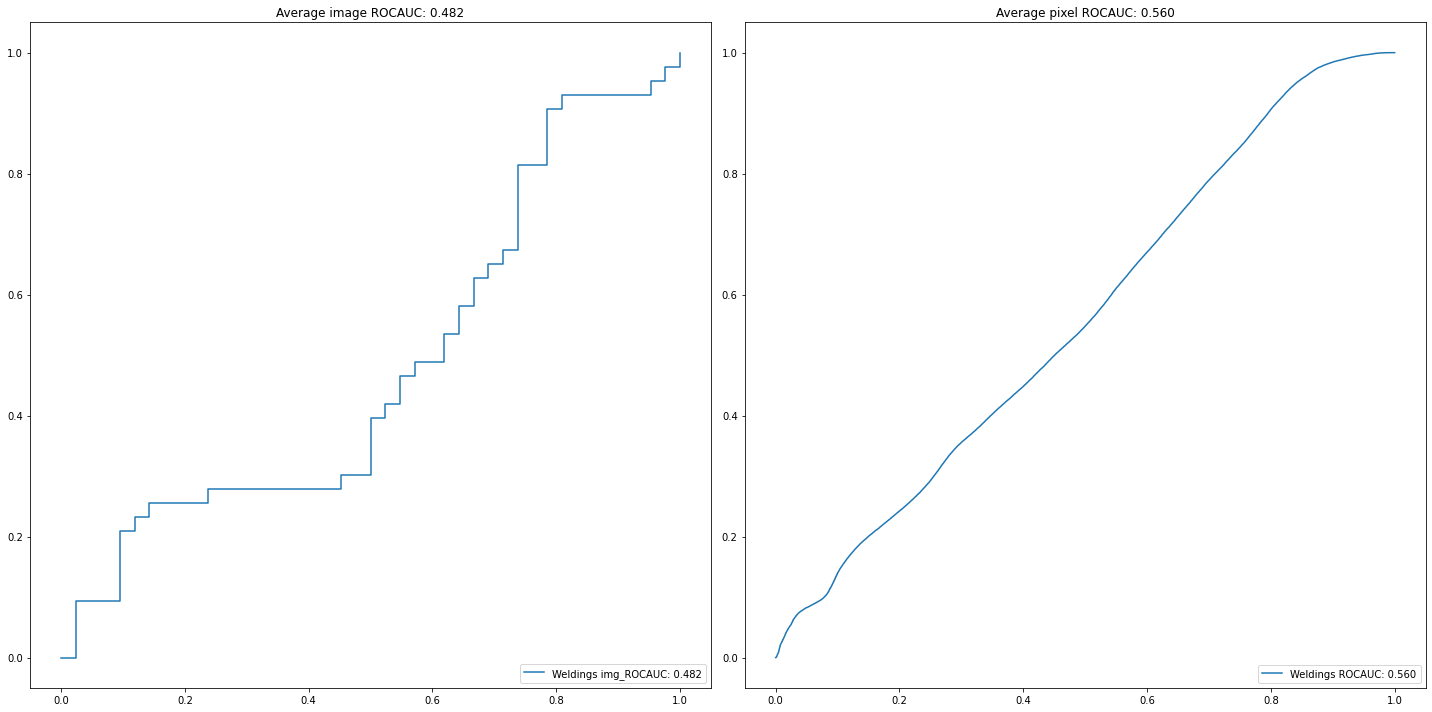

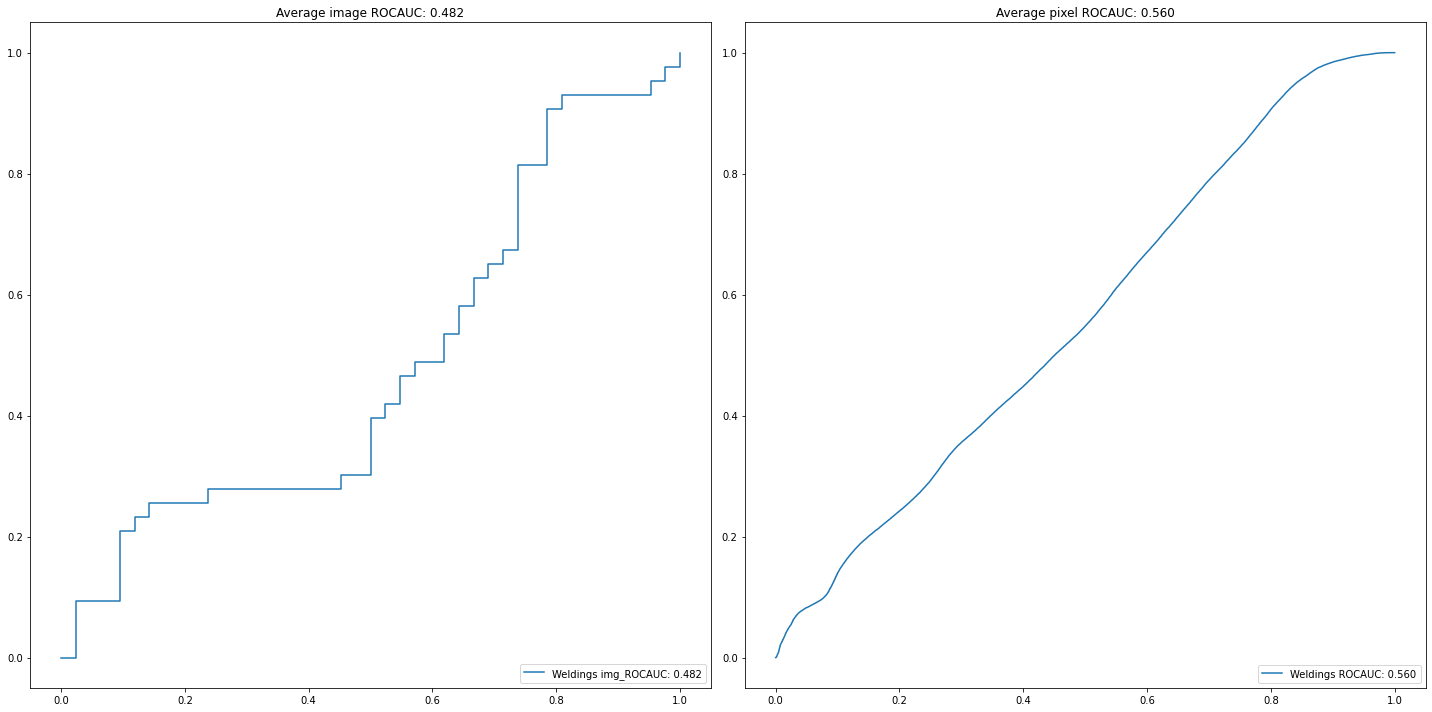

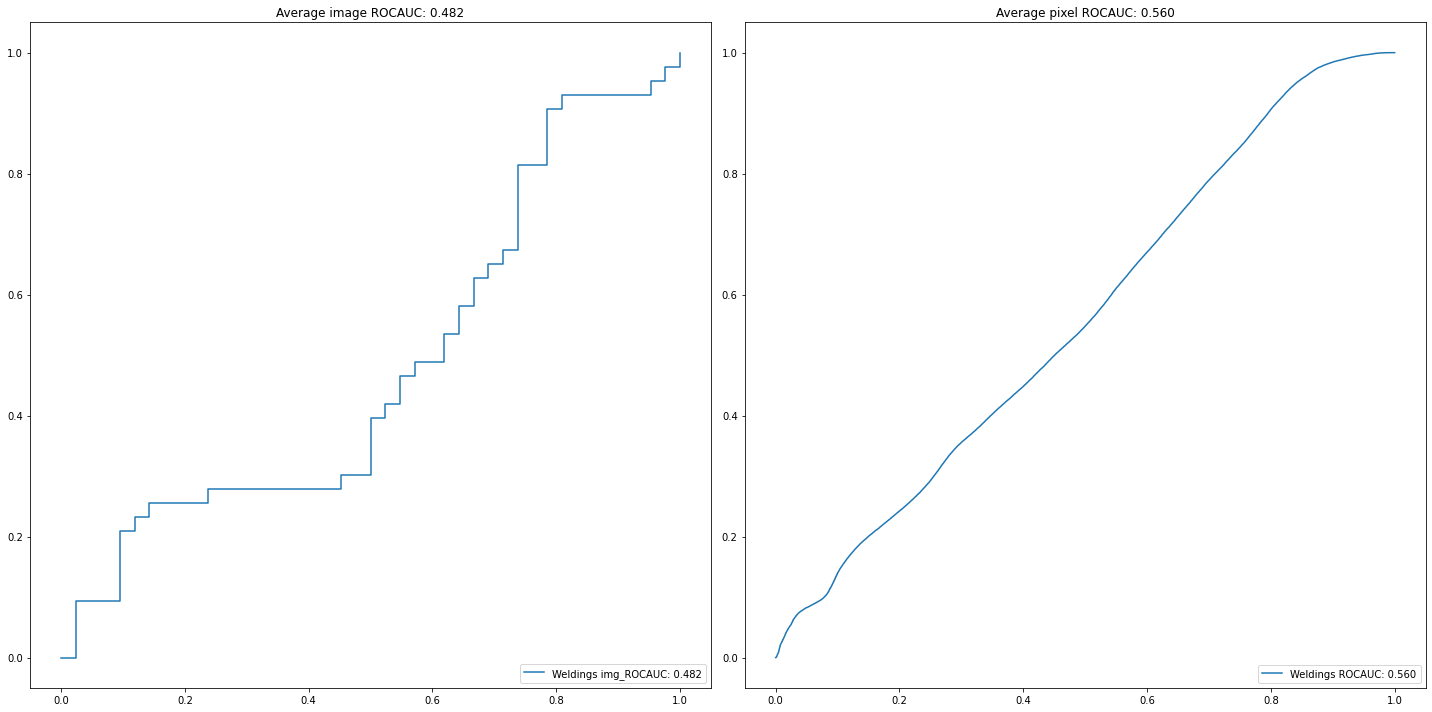

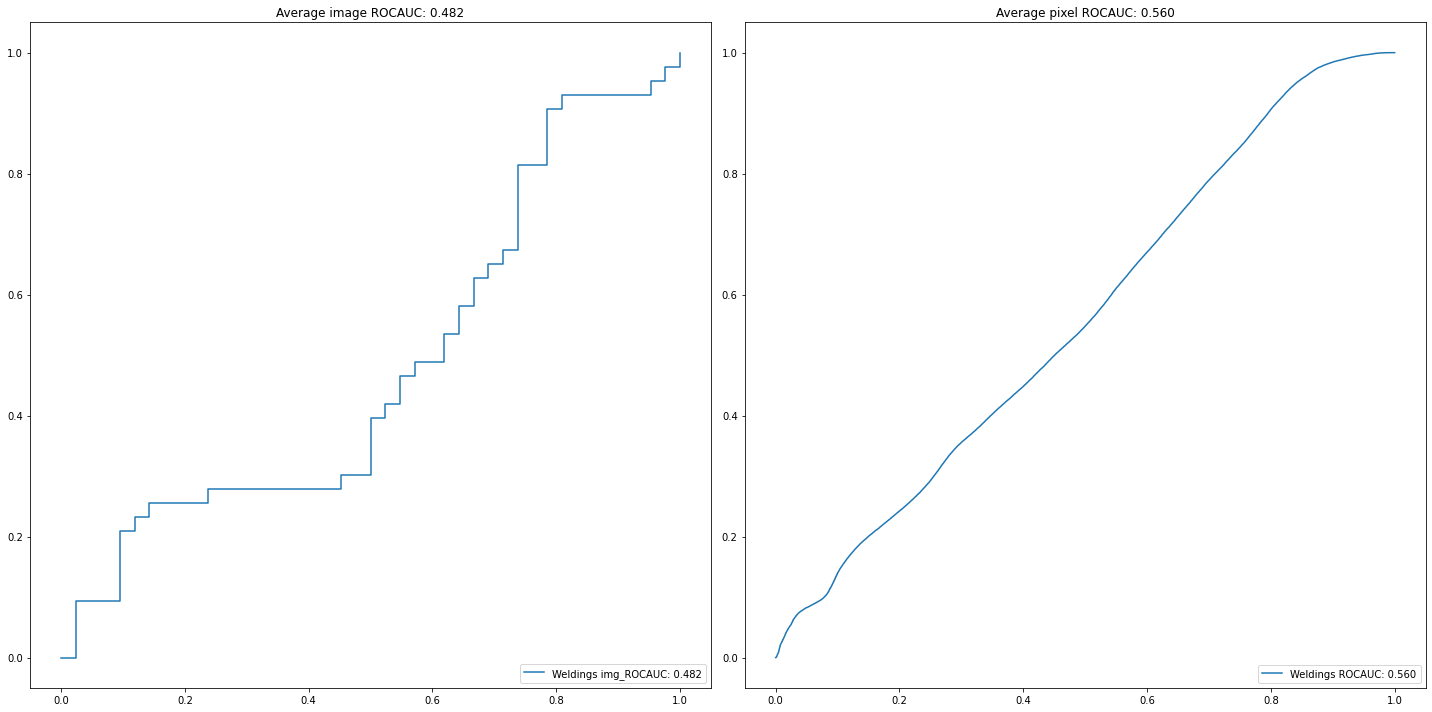

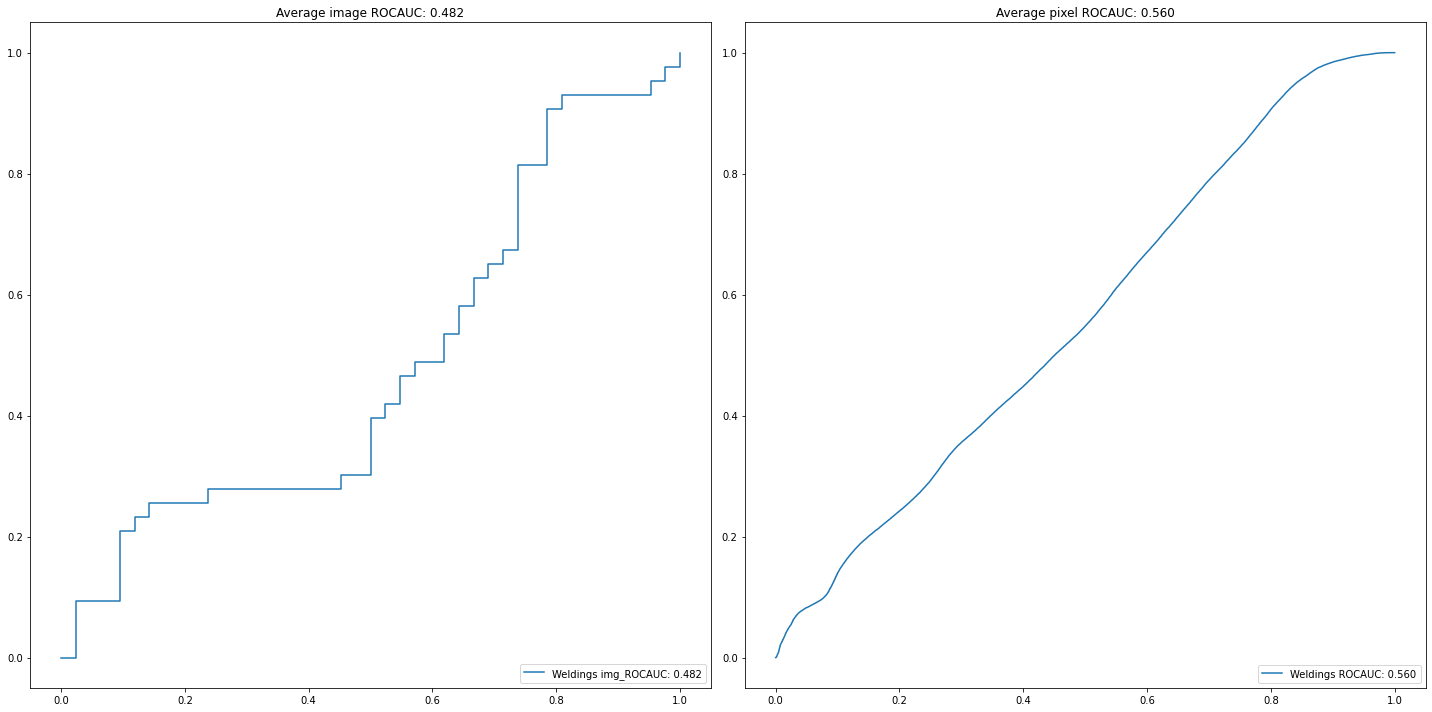

In [ ]:
save_dir = '/content/drive/MyDrive/TELECOM MS BGD/Fil_rouge/PADIM/Results/GDXray'

os.makedirs(save_dir + '/weldings',exist_ok=True)

rocauc_image, rocauc_pixel = [], []
                
for i in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    fig_img_rocauc = ax[0]
    fig_pixel_rocauc = ax[1]

    class_name='Weldings'

    total_roc_auc = []
    total_pixel_roc_auc = []
    
    # calculate image-level ROC AUC score
    img_scores = results_test.reshape(results_test.shape[0], -1).max(axis=1)
    gt_list = np.asarray(gt_list)
    fpr, tpr, _ = roc_curve(gt_list, img_scores)

    np.savetxt(f'{save_dir}/weldings/weldings_fpr_image.npy', fpr)
    np.savetxt(f'{save_dir}/weldings/weldings_tpr_image.npy', tpr)


    img_roc_auc = roc_auc_score(gt_list, img_scores)
    total_roc_auc.append(img_roc_auc)
    print('image ROCAUC: %.3f' % (img_roc_auc))
    fig_img_rocauc.plot(fpr, tpr, label='%s img_ROCAUC: %.3f' % (class_name, img_roc_auc))

    rocauc_image.append(img_roc_auc)

    # get optimal threshold
    gt_mask = np.asarray(gt_mask_list)
    precision, recall, thresholds = precision_recall_curve(gt_mask.flatten(), results_test.flatten())
    a = 2 * precision * recall
    b = precision + recall
    f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
    threshold = thresholds[np.argmax(f1)]

    # calculate per-pixel level ROCAUC
    fpr, tpr, _ = roc_curve(gt_mask.flatten(), results_test.flatten())

    np.savetxt(f'{save_dir}/weldings/weldings_fpr_pixel.npy', fpr)
    np.savetxt(f'{save_dir}/weldings/weldings_tpr_pixel.npy', tpr)

    per_pixel_rocauc = roc_auc_score(gt_mask.flatten(), results_test.flatten())
    total_pixel_roc_auc.append(per_pixel_rocauc)
    print('pixel ROCAUC: %.3f' % (per_pixel_rocauc))

    rocauc_pixel.append(per_pixel_rocauc)

    fig_pixel_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (class_name, per_pixel_rocauc))
    save_path = save_dir + f'/pictures.png'
    os.makedirs(save_dir, exist_ok=True)
    #plot_fig(test_imgs, results_test, gt_mask_list, threshold, save_dir)

    print('Average ROCAUC: %.3f' % np.mean(total_roc_auc))
    fig_img_rocauc.title.set_text('Average image ROCAUC: %.3f' % np.mean(total_roc_auc))
    fig_img_rocauc.legend(loc="lower right")

    print('Average pixel ROCUAC: %.3f' % np.mean(total_pixel_roc_auc))
    fig_pixel_rocauc.title.set_text('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
    fig_pixel_rocauc.legend(loc="lower right")

    fig.tight_layout()
    fig.savefig(os.path.join(save_dir, 'roc_curve.png'), dpi=100)
print(f'ROCAUC image : {np.mean(rocauc_image)}, len: {len(rocauc_image)}')
print(f'ROCAUC per pixel : {np.mean(rocauc_pixel)}, len: {len(rocauc_pixel)}')


In [ ]:
 save_dir = '/content/drive/MyDrive/padim'
os.makedirs(save_dir,exist_ok=True)
plot_fig(test_img=test_imgs,scores=results_test,
         gts=gt_mask_list,threshold=6,
         save_dir=save_dir)

ValueError: ignored

# Tableau des résultats
### Comparaisons des modèles pré-définis
|  Modèle pré-défini | d | t_d | ROCAUC Detection |  ROCAUC Segmentation | 
|---|---|---|---|---|
| Resnet18  | 100 |  448 |  0.4817275747508306 |  0.5601246941393481 |
| Resnet101  | 550  | 1700 |  0.570874861572536 | 0.36725612452511713  |
| Resnet152 | 550  | 1700 | 0.4640088593576966  | 0.32839356426792765  |
| Resnext50_32x4d |  550 | 1700 |  0.5913621262458472 |  0.37778831022224246 |
| Resnext101_32x8d | 550 |  1700 |  0.5885935769656699 | 0.3325480345020855  |
| Wide_resnet50_2 | 550 | 1700 |  0.5149501661129569 |  0.6663424459984638 |
| Wide_resnet101_2 | 550 | 1700  |  0.5636766334440753 |  0.33780798467986833 |

### Comparaisons des distances avec le modèle pré-défini le plus performant : 

|  Distance pré-défini |  ROCAUC Detection |  ROCAUC Segmentation |   |   |
|---|---|---|---|---|
| Mahalanobis  |   |   |   |   |
| Euclidienne  |   |  |   |   |
| ... |  |   |   |   |

### Comparaisons des valeurs de t et t_d

|  t | t_d | ROCAUC Detection |  ROCAUC Segmentation |   |
|---|---|---|---|---|
|   |   |   |   |   |
